## word2vec의 속도 개선

ch 3에서 보았던 CBOW(Continuous Bag of Words) 모델은 처리 효율이 떨어져 말뭉치에 포함된 어휘 수가 많아지면 계산량도 커진다.

따라서, 단순한 word2vec에 두가지 개선을 추가한다.

Embedding 이라는 새로운 계층을 만든다.
네거티브 샘플링 이라는 새로운 손실함수를 도입한다.
이로써 '진짜'word2vec을 완성할 수 있다.

만약 어휘가 100만개, 은닉층의 뉴런이 100개인 CBOW 모델을 생각해 보면,
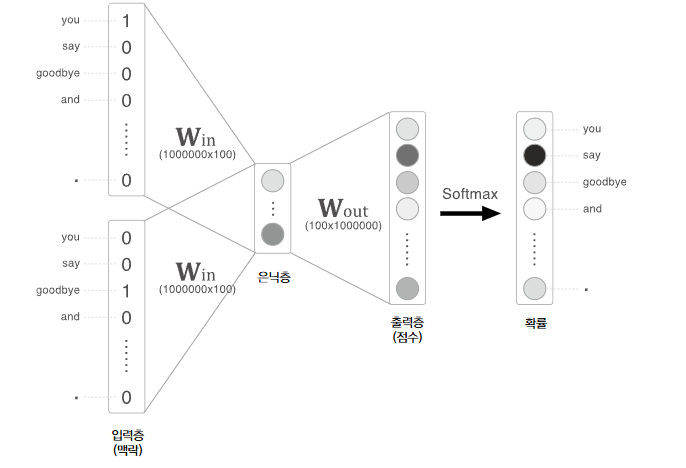

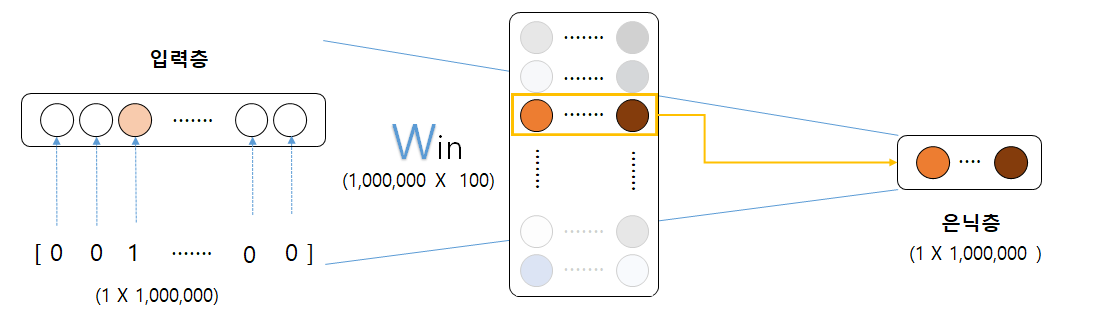

In [1]:
import numpy as np

W=np.arange(21).reshape(7,3)
W[[2,5],]

array([[ 6,  7,  8],
       [15, 16, 17]])

In [2]:
import numpy as np

class Embedding:
    """
    단어의 임베딩을 관리하는 클래스입니다.
    
    매개변수:
    W (numpy.ndarray): 초기 임베딩 가중치 (단어 수, 임베딩 차원).
    
    인스턴스 변수:
    - params (list): 가중치 리스트.
    - grads (list): 가중치의 그래디언트 리스트.
    - idx (numpy.ndarray): 현재 인덱스를 저장할 변수.
    """
    def __init__(self, W):
        # W: 초기 임베딩 가중치 (벡터)
        self.params = [W]  # 가중치를 params 리스트에 저장
        self.grads = [np.zeros_like(W)]  # 가중치의 그래디언트를 저장할 리스트 (초기값: 0)
        self.idx = None  # 인덱스를 저장할 변수

    def forward(self, idx):
        """
        순전파: 주어진 인덱스(idx)를 사용하여 임베딩 벡터를 반환합니다.
        
        매개변수:
        idx (numpy.ndarray): 선택된 단어의 인덱스 (배치 크기,).
        
        반환값:
        out (numpy.ndarray): 선택된 단어의 임베딩 벡터 (배치 크기, 임베딩 차원).
        
        예시:
        - W = np.array([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])  # (3, 2)
        - embedding = Embedding(W)
        - idx = np.array([0, 2])  # 선택된 단어 인덱스
        - out = embedding.forward(idx)  # out = [[0.1, 0.2], [0.5, 0.6]]
        """
        W, = self.params  # 가중치 W를 파라미터에서 추출
        self.idx = idx  # 현재 인덱스를 저장
        out = W[idx]  # 인덱스를 사용하여 W에서 해당하는 임베딩 벡터를 가져옴
        return out  # 출력 반환

    def backward(self, dout):
        """
        역전파: 임베딩 벡터에 대한 기울기를 계산합니다.
        
        매개변수:
        dout (numpy.ndarray): 다음 계층으로부터의 기울기 (배치 크기, 임베딩 차원).
        
        반환값:
        None
        
        예시:
        - dout = np.array([[1.0, 2.0], [3.0, 4.0]])  # (2, 2)
        - embedding.backward(dout)  # 인덱스에 따라 dW에 dout 값을 추가
        """
        dW, = self.grads  # 그래디언트를 추출
        dW[...] = 0  # 그래디언트를 0으로 초기화
        
        # idx에 있는 각 단어 ID에 대해 dout의 값을 dW에 더함
        np.add.at(dW, self.idx, dout)  # 인덱스에 따라 dout 값을 dW에 더함 
        # 기울기는 누적합산이 되어야 하기 때문임. 중복된 인덱스의 기울기를 누적하여 모든 기울기 정보를 반영.
        return None  # 역전파 시 반환할 값 없음


### backward 보충 설명

## `backward` 함수 예제 코드 비교

두 개의 `backward` 함수 예제 코드가 있으며, 두 코드의 차이점은 `dW` 행렬에 기울기를 할당하는 방식에 있습니다. 각 코드의 차이와 예시를 통해 차이점을 설명합니다.

### 첫 번째 코드 예시

```python
def backward(self, dout):
    dW = self.grads
    dW[...] = 0  # 모든 요소를 0으로 초기화
    dW[self.idx] = dout  # `self.idx`에 해당하는 행에 `dout` 할당
    return None

문제점: self.idx가 중복된 인덱스를 포함하고 있다면, dW[self.idx] = dout은 마지막 인덱스의 값만 남기고 중복된 인덱스의 기울기 정보를 덮어씁니다.
예시: self.idx = [1, 3, 1], dout = [0.5, 1.0, 0.2]일 때,
첫 번째 1번 행에 0.5가 할당되고, 3번 행에 1.0이 할당된 뒤, 두 번째 1번 행에 0.2가 할당됩니다.
결과적으로 dW[1]은 0.2로 덮어써지고, 0.5는 사라집니다.
```
```python
def backward(self, dout):
    dW = self.grads
    dW[...] = 0  # 모든 요소를 0으로 초기화

    for i, word_id in enumerate(self.idx):
        dW[word_id] += dout[i]  # 중복 인덱스가 있을 경우 더해줌
    # 또는 np.add.at(dW, self.idx, dout) 사용 가능

    return None

해결: 중복된 인덱스에 대해 덮어쓰지 않고, 각 인덱스의 기울기를 += 연산을 통해 누적합니다.
예시: 동일하게 self.idx = [1, 3, 1]이고 dout = [0.5, 1.0, 0.2]인 경우,
첫 번째 1번 행에 0.5가 더해지고, 3번 행에 1.0이 더해진 뒤, 다시 1번 행에 0.2가 더해져서 dW[1]은 0.5 + 0.2 = 0.7이 됩니다.
결과적으로 dW[1] = 0.7, dW[3] = 1.0이 됩니다.

In [3]:
sample_emd=Embedding(np.random.randn(3,7))
# sample_emd 인스턴스는 3개의 단어에 대해 각각 임베딩 크기가 7인 임베딩 행렬
sample_emd.forward(2)

array([-2.34573575, -0.40773726, -0.46416522,  1.51942991, -0.54485647,
        0.8135989 , -0.43137574])

In [4]:
sample_emd.params

[array([[ 0.48447598, -1.03652719,  0.60650489, -1.25314381,  0.03719891,
         -0.05989916,  1.27314447],
        [-0.49598938, -0.71191361,  0.34324916, -0.2638355 , -0.55238612,
         -0.6882562 ,  0.82666847],
        [-2.34573575, -0.40773726, -0.46416522,  1.51942991, -0.54485647,
          0.8135989 , -0.43137574]])]

In [5]:
sample_emd.grads

[array([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])]

In [6]:
sample_emd.forward(0)
sample_emd.backward(np.random.randn(7))

In [7]:
sample_emd.grads

[array([[-0.45672087, -0.75981898, -0.76368107,  0.58570912, -0.96773306,
          1.29750377, -0.21709349],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ]])]

## 네거티브 샘플링 임베딩

네거티브 샘플링(negative sampling)은 자연어 처리(NLP)에서 단어 임베딩을 학습하기 위한 기법으로, Word2Vec 모델에서 널리 사용됩니다. 이 방법은 특히 대규모 데이터셋에서 단어 벡터를 효율적으로 학습할 수 있도록 도와줍니다.

### 1. 기본 아이디어

전통적인 방법에서는 모든 단어 쌍에 대해 소프트맥스(softmax) 함수를 사용하여 확률을 계산합니다. 그러나 이 방식은 계산 비용이 매우 크기 때문에 비효율적입니다. 네거티브 샘플링은 다음과 같은 과정을 통해 이 문제를 해결합니다:

- **양성 샘플(Positive Samples)**: 실제로 관찰된 단어 쌍, 즉 주어진 문맥에서 실제로 나타나는 단어 쌍을 의미합니다.
- **네거티브 샘플(Negative Samples)**: 랜덤하게 선택된 단어 쌍으로, 관찰되지 않은 단어 쌍입니다. 이러한 네거티브 샘플을 사용하여 학습의 효율성을 높입니다.

### 2. 학습 과정

네거티브 샘플링의 학습 과정은 다음과 같습니다:

1. **샘플링**: 문맥 단어(context word)와 주어진 단어(target word)의 쌍을 선택합니다. 이 쌍은 양성 샘플로 사용됩니다. 그 후, 몇 개의 네거티브 샘플을 랜덤하게 선택합니다.

2. **확률 계산**: 양성 샘플과 네거티브 샘플의 임베딩을 사용하여 각 샘플에 대한 확률을 계산합니다. 
   - 양성 샘플에 대해 높은 확률을 목표로 하고, 네거티브 샘플에 대해서는 낮은 확률을 목표로 합니다.
   
3. **손실 함수(Loss Function)**: 양성 샘플은 성공적으로 예측해야 하고, 네거티브 샘플은 실패해야 하므로, 이를 기반으로 손실 함수를 정의합니다. 주로 시그모이드 함수와 크로스 엔트로피 손실을 사용합니다.

### 3. 장점

- **효율성**: 모든 단어 쌍에 대한 계산을 피하고, 일부 샘플만 사용하여 학습 속도를 높입니다.
- **메모리 절약**: 대규모 코퍼스를 처리할 때 필요한 메모리를 줄입니다.
- **성능 향상**: 더 많은 네거티브 샘플을 통해 임베딩의 품질을 향상시킬 수 있습니다.

### 4. 결론

네거티브 샘플링은 대규모 데이터셋에서 단어 임베딩을 효과적으로 학습하는 데 유용한 기법입니다. 이 방법을 통해 모델의 계산 비용을 줄이고 학습 속도를 높이며, 단어 벡터의 품질을 향상시킬 수 있습니다. 이러한 이유로 네거티브 샘플링은 자연어 처리 분야에서 매우 중요한 역할을 하고 있습니다.


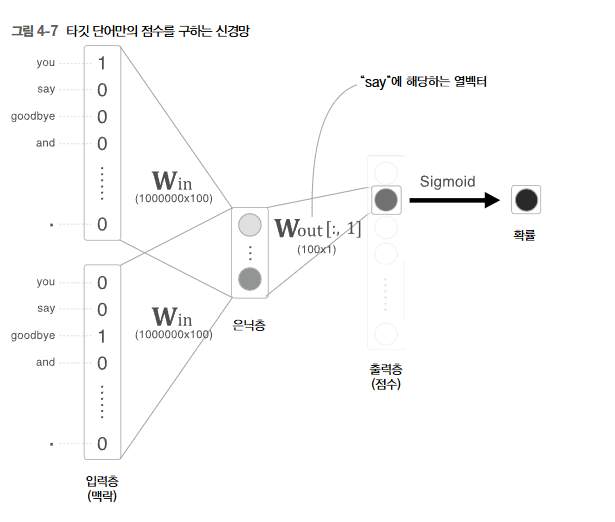

In [8]:
x=np.expand_dims(np.random.randn(100),axis=0)
x

array([[-0.26113716,  0.88500939,  0.63798282,  0.00538796,  0.58210645,
         0.03881187,  0.8445778 ,  1.59162477,  0.85635281, -0.13023251,
         1.39550323,  0.10098588, -0.42434718, -0.24612971,  1.22964347,
         0.53189967,  0.29511498, -0.86946091, -0.56448179, -0.56940136,
        -0.40295846, -0.9752247 , -0.15437978,  0.60575536, -0.88892335,
         0.57923928, -1.04418722, -0.06913161,  0.7549947 ,  0.8013416 ,
        -1.42660929, -1.2253987 ,  0.55905959, -0.27076447,  1.33900544,
         0.45237348, -0.12619222,  0.63888518, -0.40955931, -1.72985057,
         1.72370594, -2.02817911, -0.30482055, -1.06797582,  0.01348069,
        -0.93121261,  0.10814449,  2.3888411 ,  0.07263898,  0.58486649,
        -0.72116042, -1.38922273,  0.92102048,  0.02571168,  0.9830757 ,
         0.29124051, -0.0312804 ,  1.72297255, -0.16850721, -1.94132637,
        -0.62799224,  0.35656139,  1.84813963,  0.94846268, -1.69692197,
        -0.08418687, -1.45830687,  0.37209526,  0.1

In [9]:
x[:,1]

array([0.88500939])

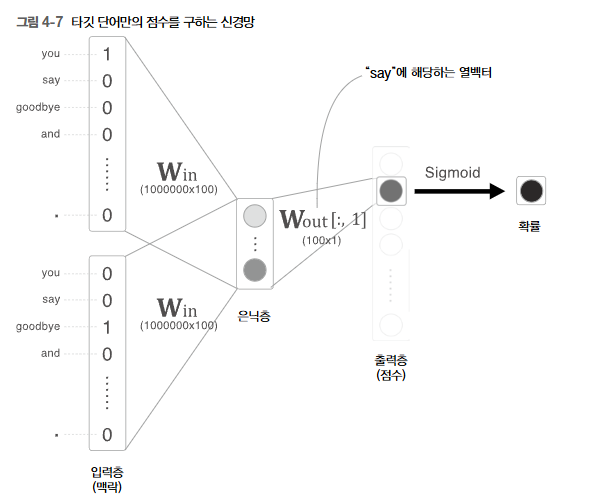
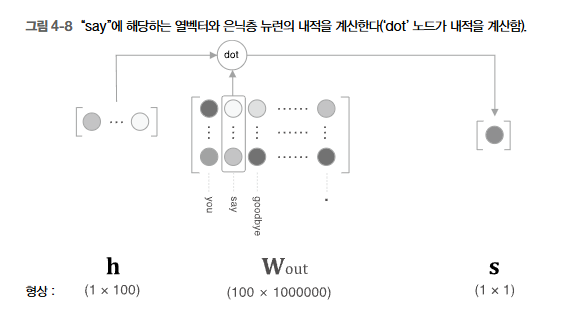
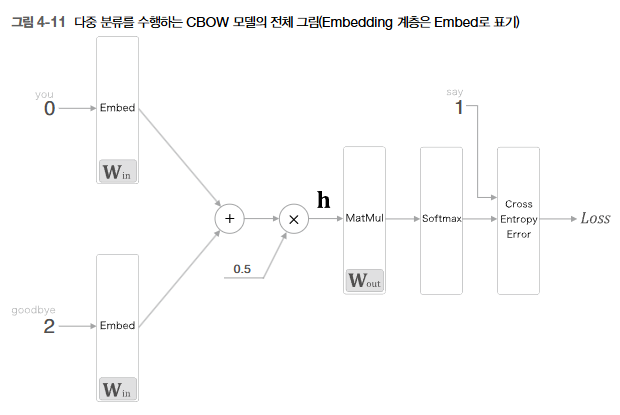
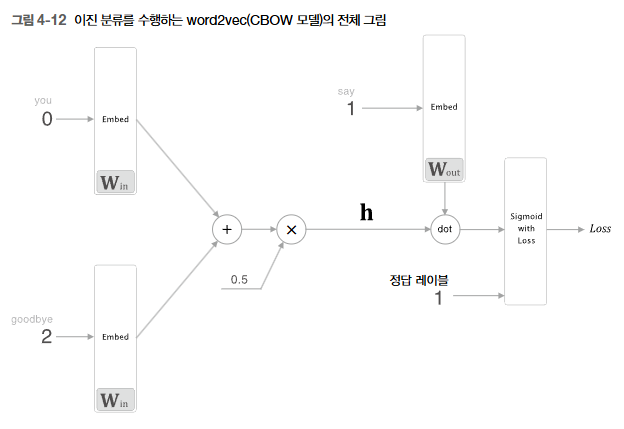

In [10]:
class Embedding:
    def __init__(self, W):
        """
        임베딩 레이어를 초기화하는 생성자.

        - Args:
          - W (numpy.ndarray): 초기 임베딩 가중치 행렬.
                              각 행은 하나의 단어에 해당하는 임베딩 벡터를 나타냄.
                              가중치 행렬의 크기는 (단어 개수, 임베딩 차원)임.
          
        - 예시:
          - W = np.array([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])  # (3, 2)
          - embedding = Embedding(W)
        """
        self.params = [W]  # 가중치를 params 리스트에 저장
        self.grads = [np.zeros_like(W)]  # 가중치의 그래디언트를 저장할 리스트 (초기값: 0)
        self.idx = None  # 인덱스를 저장할 변수

    def forward(self, idx):
        """
        주어진 인덱스에 해당하는 임베딩 벡터를 반환하는 순전파 함수.

        - Args:
          - idx (int 또는 numpy.ndarray): 단어의 인덱스 또는 인덱스 배열.
                                          인덱스는 임베딩 가중치 행렬 W에서 행을 선택함.
        
        - Returns:
          - numpy.ndarray: 선택된 인덱스에 해당하는 임베딩 벡터. 
                           idx가 스칼라일 경우 (임베딩 차원,) 크기의 벡터를 반환하고, 
                           idx가 배열일 경우 (배열 크기, 임베딩 차원) 크기의 행렬을 반환함.
        
        - 예시:
          - idx = 1
          - out = embedding.forward(idx)  # out = [0.3, 0.4]
          - idx_array = np.array([0, 2])
          - out_array = embedding.forward(idx_array)  # out_array = [[0.1, 0.2], [0.5, 0.6]]
        """
        W, = self.params  # 가중치 W를 파라미터에서 추출
        self.idx = idx  # 현재 인덱스를 저장
        out = W[idx]  # 인덱스를 사용하여 W에서 해당하는 임베딩 벡터를 가져옴
        return out  # 선택된 임베딩 벡터를 반환

    def backward(self, dout):
        """
        임베딩 가중치에 대한 그래디언트를 계산하는 역전파 함수.

        - Args:
          - dout (numpy.ndarray): 출력에 대한 그래디언트. forward에서 반환된 임베딩 벡터에 대한 손실의 미분값.
                                  dout의 크기는 forward에서 반환된 값과 동일.
        
        - Returns:
          - None: 그래디언트는 내부적으로 `self.grads`에 저장되며, 별도의 반환값은 없음.
        
        - 예시:
          - dout = np.array([[1.0, 2.0], [3.0, 4.0]])  # (2, 2)
          - embedding.backward(dout)  # 인덱스에 따라 dW에 dout 값을 추가
        """
        dW, = self.grads  # 그래디언트를 추출
        dW[...] = 0  # 그래디언트를 0으로 초기화 (기존 그래디언트와의 누적 방지)
        
        # np.add.at은 인덱스 위치에 dout의 값을 더함.
        # 이는 동일한 인덱스가 여러 번 나오는 경우에도 각각의 dout을 올바르게 누적시킴.
        np.add.at(dW, self.idx, dout)  
        
        return None  # 역전파 시 반환할 값 없음


In [11]:
sample_emd=Embedding(np.random.randn(3,7))
sample_emd.forward(2)
sample_emd.backward(np.random.randn(7))

sample_emd.grads

[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 1.24253329,  2.8336708 , -0.30368037,  0.14023999, -0.65264071,
          0.87824672, -0.4900657 ]])]

In [12]:
from common.np import *  # numpy를 import합니다.
import collections  # collections 모듈을 import합니다.


class EmbeddingDot:
    def __init__(self, W):
        """
        EmbeddingDot 레이어를 초기화하는 생성자.

        - Args:
          - W (numpy.ndarray): 초기 임베딩 가중치 행렬.
                              각 행은 하나의 단어에 해당하는 임베딩 벡터를 나타냄.
                              가중치 행렬의 크기는 (단어 개수, 임베딩 차원)임.
        
        - 예시:
          - W = np.array([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])  # (3, 2)
          - embedding_dot = EmbeddingDot(W)
        """
        self.embed = Embedding(W)  # Embedding 클래스를 사용하여 임베딩 객체 생성
        self.params = self.embed.params  # Embedding의 파라미터를 가져옴
        self.grads = self.embed.grads  # Embedding의 그래디언트를 가져옴
        self.cache = None  # 캐시를 초기화

    def forward(self, h, idx):
        """
        순전파: 입력 벡터와 타겟 단어의 인덱스를 사용하여 내적을 계산.

        - Args:
          - h (numpy.ndarray): 입력 벡터 (배치 크기, 임베딩 차원).
          - idx (int 또는 numpy.ndarray): 타겟 단어의 인덱스 또는 인덱스 배열.
        
        - Returns:
          - numpy.ndarray: 타겟 단어의 내적 결과 (배치 크기,).
        
        - 예시:
          - h = np.array([[0.1, 0.2], [0.3, 0.4]])  # (2, 2)
          - idx = np.array([0])  # 타겟 단어 인덱스
          - out = embedding_dot.forward(h, idx)  # out = [0.5]
        """
        target_W = self.embed.forward(idx)  # 인덱스를 사용하여 임베딩 벡터를 가져옴
        out = np.sum(target_W * h, axis=1)  # 타겟 임베딩 벡터와 입력 벡터의 내적을 계산

        self.cache = (h, target_W)  # 역전파를 위한 캐시 저장
        return out  # 출력 반환

    def backward(self, dout):
        """
        역전파: 다음 층으로부터의 그래디언트를 사용하여 입력 벡터에 대한 그래디언트를 계산.

        - Args:
          - dout (numpy.ndarray): 다음 층으로부터의 그래디언트 (배치 크기,).
        
        - Returns:
          - numpy.ndarray: 입력 벡터에 대한 그래디언트 (배치 크기, 임베딩 차원).
        
        - 예시:
          - dout = np.array([1.0, 2.0])  # (2,)
          - dh = embedding_dot.backward(dout)  # 입력 벡터에 대한 그래디언트 계산
        """
        h, target_W = self.cache  # 캐시에서 입력 벡터와 타겟 임베딩 벡터를 가져옴
        
        print(dout.shape)
        dout = dout.reshape(dout.shape[0], 1)  # dout을 2차원으로 변환
        print(dout.shape) 
        
        dtarget_W = dout * h  # 타겟 임베딩 벡터에 대한 그래디언트 계산
        self.embed.backward(dtarget_W)  # Embedding 레이어의 역전파 수행
        dh = dout * target_W  # 입력 벡터에 대한 그래디언트 계산
        return dh  # 입력 벡터에 대한 그래디언트를 반환


In [13]:
import numpy as np

# 임베딩 가중치 행렬 W: 어휘에 대한 임베딩 벡터 (3개의 단어, 2차원 벡터)
W = np.array([
    [0.2, 0.8],  # 첫 번째 단어 ('I')의 임베딩 벡터 (0번 인덱스)
    [0.4, 0.1],  # 두 번째 단어 ('love')의 임베딩 벡터 (1번 인덱스)
    [0.7, 0.3]   # 세 번째 단어 ('you')의 임베딩 벡터 (2번 인덱스)
])  # shape: (3, 2)

# 'love'의 주변 단어는 'I'와 'you'라고 가정합니다.
context_words = np.array([0, 2])  # 'I'와 'you'의 인덱스
context_vectors = W[context_words]  # 주변 단어들의 임베딩 벡터
h = np.mean(context_vectors, axis=0)  # 주변 단어들의 평균을 계산

h


array([0.45, 0.55])

In [14]:
# idx: 타겟 단어들의 인덱스
idx = np.array([1])  # 첫 번째 샘플의 타겟은 'love'(1번 인덱스)

# dout: 역전파 시 사용할 그래디언트 값
dout = np.array([1.0])  # 첫 번째 샘플에 대한 그래디언트

# EmbeddingDot 클래스 인스턴스 생성
embedding_dot_layer = EmbeddingDot(W)

# 순전파 수행
out = embedding_dot_layer.forward(h, idx)
print("Forward output:", out)

# 역전파 수행
dh = embedding_dot_layer.backward(dout)
print("Backward output:", dh)

Forward output: [0.235]
(1,)
(1, 1)
Backward output: [[0.4 0.1]]


In [15]:
embedding_dot_layer.params

[array([[0.2, 0.8],
        [0.4, 0.1],
        [0.7, 0.3]])]

In [16]:
embedding_dot_layer.embed.grads

[array([[0.  , 0.  ],
        [0.45, 0.55],
        [0.  , 0.  ]])]

In [17]:
embedding_dot_layer.grads

[array([[0.  , 0.  ],
        [0.45, 0.55],
        [0.  , 0.  ]])]

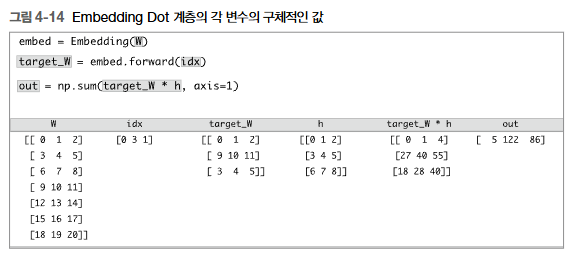

## 네거티브 샘플링의 예시

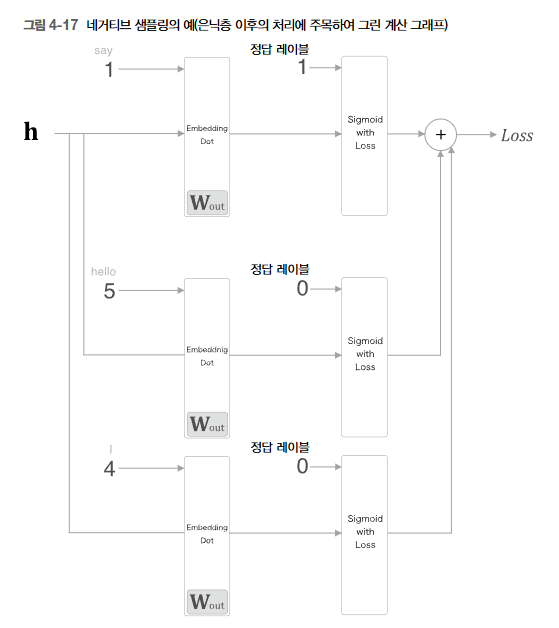

In [18]:
p=[0.7,0.29,0.01]
new_p=np.power(p,0.75)

new_p/=np.sum(new_p)
new_p

array([0.64196878, 0.33150408, 0.02652714])

In [19]:
corpus=np.array([0,1,2,3,4,1,2,3])
counts = collections.Counter()
for word_id in corpus:
    counts[word_id] += 1

counts

Counter({1: 2, 2: 2, 3: 2, 0: 1, 4: 1})

In [20]:
np.zeros(len(counts))

array([0., 0., 0., 0., 0.])

In [21]:
import collections  # collections 모듈을 사용해 단어 빈도를 계산
import numpy as np  # numpy를 import합니다.

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        """
        UnigramSampler 클래스의 초기화 메서드.
        ---> [[4 3 2]
              [0 1 2]
              [1 2 4]]

        부정 샘플러를 생성

        - Args:
            - corpus (list[int]): 말뭉치, 각 단어를 ID로 변환한 리스트.
            - power (float): 확률 계산 시 사용할 power 값 (unigram 분포 조정).
            - sample_size (int): 샘플링할 단어의 수.
        
        - 예시:
            - corpus = [0, 1, 2, 0, 1, 3, 0, 4, 1]  # 단어 ID의 리스트
            - sampler = UnigramSampler(corpus, power=0.75, sample_size=2)
        """
        self.sample_size = sample_size  # 샘플링할 음성 데이터 개수
        self.vocab_size = None  # 어휘 크기 (코퍼스에 등장하는 단어의 수)
        self.word_p = None  # 각 단어의 확률분포 (unigram 확률)

        counts = collections.Counter()  # 각 단어의 빈도수를 계산하는 Counter 객체
        for word_id in corpus:
            counts[word_id] += 1  # 코퍼스에서 각 단어의 출현 빈도수 추가
            
        vocab_size = len(counts)  # 어휘 크기(단어의 개수)
        self.vocab_size = vocab_size  # 어휘 크기 저장
        
        self.word_p = np.zeros(vocab_size)  # 단어 확률을 저장할 배열 초기화
        for i in range(vocab_size):
            self.word_p[i] = counts[i]  # 각 단어의 빈도수 저장
        
        # word_p에 power 값을 적용해 확률을 왜곡 (자주 등장하는 단어가 더 높은 확률을 가짐)
        self.word_p = np.power(self.word_p, power)
        
        # 확률분포가 합이 1이 되도록 정규화
        self.word_p /= np.sum(self.word_p)
        
    def get_negative_sample(self, target):
        """
        음성 샘플링을 수행하는 메서드.

        - Args:
            - target (numpy.ndarray): 타겟 단어의 인덱스 (미니배치 크기의 배열).
        
        - Returns:
            - numpy.ndarray: 타겟을 제외한 음성 샘플 단어 인덱스 배열 (배치 크기 x 샘플 크기).
        
        - 예시:
            - target = np.array([0, 1])  # 타겟 단어 인덱스
            - negative_samples = sampler.get_negative_sample(target)
            - print(negative_samples)  # 출력: 예를 들어 [[2, 3], [4, 2]]
        """
        batch_size = target.shape[0]  # 미니배치 크기
        
        # 음성 샘플을 저장할 배열 초기화 (batch_size x sample_size 크기)
        negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)
        
        for i in range(batch_size):
            p = self.word_p.copy()  # 확률분포 복사
            target_idx = target[i]  # 타겟 단어 인덱스
            p[target_idx] = 0  # 타겟 단어는 음성 샘플에 포함되지 않도록 확률 0으로 설정
            p /= p.sum()  # 확률 분포 다시 정규화 (합이 1이 되도록)
            
            # 타겟 단어를 제외한 단어들 중에서 음성 샘플링 수행
            negative_sample[i, :] = np.random.choice(
                self.vocab_size, size=self.sample_size, replace=False, p=p)  # 음성 샘플링
        return negative_sample  # 음성 샘플링 결과 반환


In [22]:
np.random.choice(7, 3, replace=False, p=[0.3, 0.2, 0.1, 0.15, 0.05, 0.1, 0.1])

array([1, 5, 0])

In [23]:
corpus=np.array([0,1,2,3,4,1,2,3])
power=0.75
sample_size=3

sampler=UnigramSampler(corpus,power,sample_size)
print(sampler)
rs=sampler.get_negative_sample(corpus) # np.array([1,3,0])은 긍정 샘플들임
print(rs) # 부정 샘플링 뽑기

[[3 2 4]
 [4 3 2]
 [4 0 3]
 [0 1 2]
 [3 0 2]
 [0 3 2]
 [1 4 3]
 [0 2 4]]


In [38]:
rs[:1]

array([[4, 3, 2]])

In [94]:
from common.layers import SigmoidWithLoss  # SigmoidWithLoss 레이어를 임포트
import numpy as np  # numpy를 import합니다.

class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        """
        NegativeSamplingLoss 클래스의 초기화 메서드.

        긍정과 부정 단어 임베딩 벡터를 추출함

        - Args:
            - W (numpy.ndarray): 임베딩 가중치 행렬.
            - corpus (list[int]): 코퍼스 (각 단어가 ID로 변환된 리스트).
            - power (float): 확률 분포를 제어하는 파라미터 (기본값 0.75).
            - sample_size (int): 음성 샘플링할 단어의 수 (기본값 5).
        
        - 예시:
            - W = np.random.randn(vocab_size, embedding_size)  # 임베딩 가중치 초기화
            - corpus = [0, 1, 2, 0, 1, 3, 0, 4, 1]  # 단어 ID의 리스트
            - nsl = NegativeSamplingLoss(W, corpus)
        """
        self.sample_size = sample_size  # 음성 샘플링할 단어 수
        self.sampler = UnigramSampler(corpus, power, sample_size)  # UnigramSampler 객체 생성
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]  # SigmoidWithLoss 레이어 생성 (부정 예 + 긍정 예)
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]  # EmbeddingDot 레이어 생성

        self.params, self.grads = [], []  # 파라미터와 그래디언트를 저장할 리스트 초기화
        
        # 각 EmbeddingDot 레이어의 파라미터와 그래디언트를 저장
        for layer in self.embed_dot_layers:
            self.params += layer.params  # 파라미터 추가
            self.grads += layer.grads  # 그래디언트 추가
            
    def forward(self, h, target):
        """
        순전파 메서드 (forward propagation).

        - Args:
            - h (numpy.ndarray): 입력 벡터 (문맥 벡터).
            - target (numpy.ndarray): 타겟 단어 인덱스.
        
        - Returns:
            - float: 손실 값 (loss).
        
        - 예시:
            - h = np.random.randn(batch_size, embedding_size)  # 문맥 벡터
            - target = np.array([0, 1])  # 타겟 단어 인덱스
            - loss = nsl.forward(h, target)
        """
        batch_size = target.shape[0]  # 배치 크기
        negative_sample = self.sampler.get_negative_sample(target)  # 음성 샘플링을 통해 음성 단어 인덱스 생성
        
        # 긍정적 예의 순전파
        score = self.embed_dot_layers[0].forward(h, target)  # 타겟 단어에 대한 EmbeddingDot 계산 
        correct_label = np.ones(batch_size, dtype=np.int32)  # 긍정 예의 정답 레이블 (1로 설정)
        loss = self.loss_layers[0].forward(score, correct_label)  # SigmoidWithLoss 계산
        
        # 부정적 예의 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)  # 부정 예의 정답 레이블 (0으로 설정)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]  # 음성 샘플에서 i번째 단어 인덱스 선택
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)  # 음성 단어에 대한 EmbeddingDot 계산
            loss += self.loss_layers[1 + i].forward(score, negative_label)  # SigmoidWithLoss 계산 및 손실 값 추가
            
        return loss  # 최종 손실 반환
    
    def backward(self, dout=1):
        """
        역전파 메서드 (backward propagation).

        - Args:
            - dout (float): 손실에 대한 미분 값 (기본값 1).
        
        - Returns:
            - numpy.ndarray: 입력 벡터 h에 대한 그래디언트.
        
        - 예시:
            - dh = nsl.backward(dout=1)  # 역전파 수행
        """
        dh = 0  # 입력 벡터에 대한 그래디언트 초기화
        
        # 각 손실 레이어와 EmbeddingDot 레이어에 대해 역전파 수행
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)  # 손실에 대한 역전파 (SigmoidWithLoss)
            dh += l1.backward(dscore)  # EmbeddingDot 레이어에 대한 역전파 수행 후 결과를 더함
            
        return dh  # 입력 벡터에 대한 최종 그래디언트 반환


In [95]:
for l0, l1 in zip(['a','b','c'], [1,2,3]):
            print(l0)
            print(l1)

a
1
b
2
c
3


In [96]:
import numpy as np

# 임베딩 가중치 행렬 W: 어휘에 대한 임베딩 벡터 (3개의 단어, 2차원 벡터)
W = np.array([
    [0.2, 0.8],  # 첫 번째 단어 ('I')의 임베딩 벡터 (0번 인덱스)
    [0.4, 0.1],  # 두 번째 단어 ('love')의 임베딩 벡터 (1번 인덱스)
    [0.7, 0.3]   # 세 번째 단어 ('you')의 임베딩 벡터 (2번 인덱스)
])  # shape: (3, 2)

# 'love'의 주변 단어는 'I'와 'you'라고 가정합니다.
context_words = np.array([0, 2])  # 'I'와 'you'의 인덱스
context_vectors = W[context_words]  # 주변 단어들의 임베딩 벡터
h = np.mean(context_vectors, axis=0)  # 주변 단어들의 평균을 계산
idx = np.array([1]) 
h

array([0.45, 0.55])

In [97]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])  # 코퍼스 (샘플 단어 인덱스)

In [98]:
model=NegativeSamplingLoss(W,corpus)
model.embed_dot_layers

In [99]:
from common.util import create_contexts_target

contexts, target = create_contexts_target(corpus, 1)

In [102]:
# 예시 코드
W = np.random.randn(3, 2)  # 3개의 임베딩 벡터
idx = 2  # 유효한 인덱스 (0, 1, 2)
target = np.array([0, 1, 2])  # 타겟 단어 인덱스


W,target

(array([[-0.3622325 , -0.42183688],
        [ 1.07457572,  0.03045228],
        [ 1.43112317, -0.47473581]]),
 array([0, 1, 2]))

In [103]:
# EmbeddingDot의 forward 메서드 호출
embedding_dot = EmbeddingDot(W)
output = embedding_dot.forward(h, target)  # h는 문맥 벡터
output

array([-0.39501491,  0.50030783,  0.38290073])

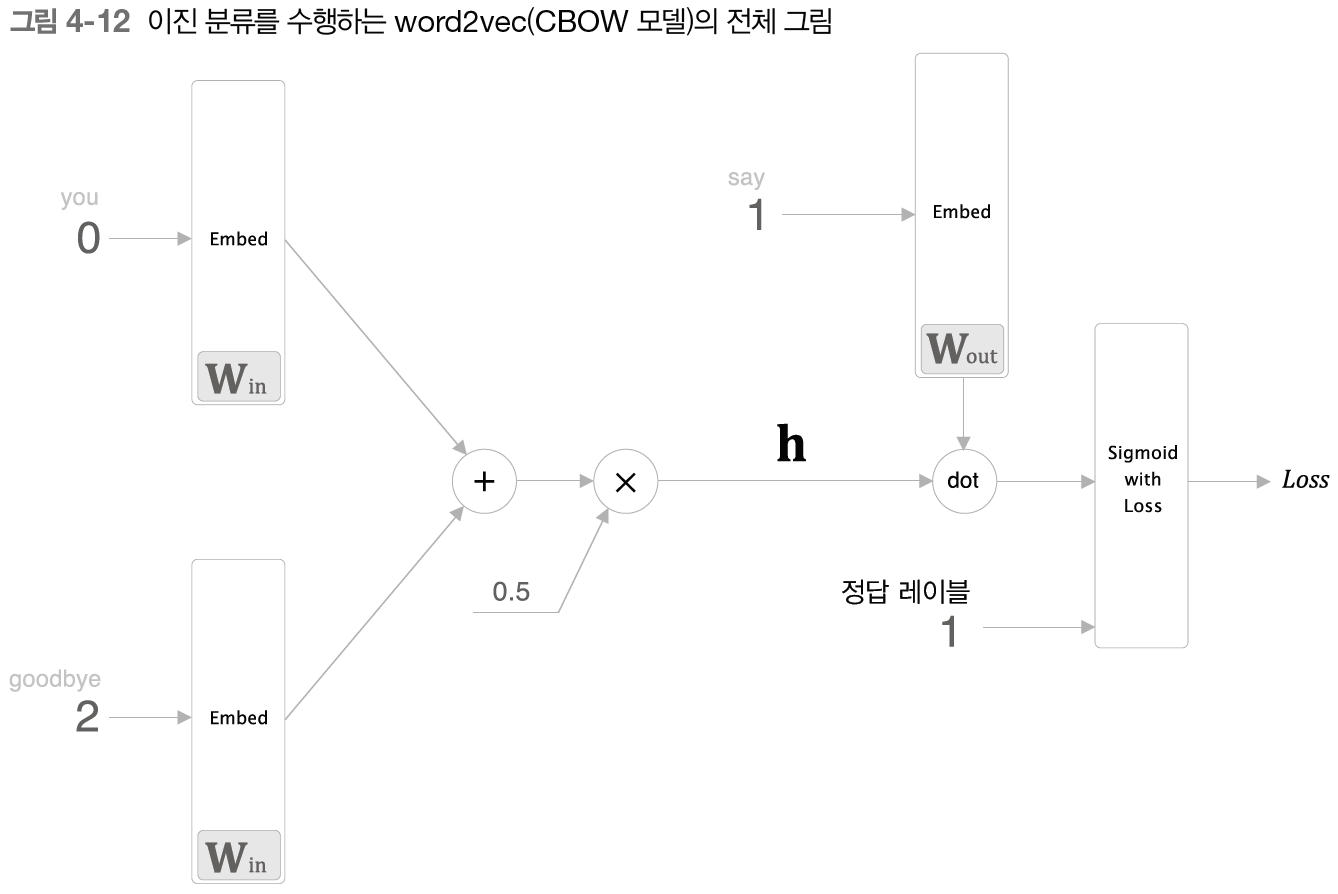

In [104]:
from dataset import ptb
from common.util import create_contexts_target
from common import config

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, 1)

In [105]:
corpus,word_to_id,len(word_to_id)

(array([ 0,  1,  2, ..., 39, 26, 24]),
 {'aer': 0,
  'banknote': 1,
  'berlitz': 2,
  'calloway': 3,
  'centrust': 4,
  'cluett': 5,
  'fromstein': 6,
  'gitano': 7,
  'guterman': 8,
  'hydro-quebec': 9,
  'ipo': 10,
  'kia': 11,
  'memotec': 12,
  'mlx': 13,
  'nahb': 14,
  'punts': 15,
  'rake': 16,
  'regatta': 17,
  'rubens': 18,
  'sim': 19,
  'snack-food': 20,
  'ssangyong': 21,
  'swapo': 22,
  'wachter': 23,
  '<eos>': 24,
  'pierre': 25,
  '<unk>': 26,
  'N': 27,
  'years': 28,
  'old': 29,
  'will': 30,
  'join': 31,
  'the': 32,
  'board': 33,
  'as': 34,
  'a': 35,
  'nonexecutive': 36,
  'director': 37,
  'nov.': 38,
  'mr.': 39,
  'is': 40,
  'chairman': 41,
  'of': 42,
  'n.v.': 43,
  'dutch': 44,
  'publishing': 45,
  'group': 46,
  'rudolph': 47,
  'and': 48,
  'former': 49,
  'consolidated': 50,
  'gold': 51,
  'fields': 52,
  'plc': 53,
  'was': 54,
  'named': 55,
  'this': 56,
  'british': 57,
  'industrial': 58,
  'conglomerate': 59,
  'form': 60,
  'asbestos': 61,

In [106]:
contexts,target

(array([[  0,   2],
        [  1,   3],
        [  2,   4],
        ...,
        [258,  39],
        [ 64,  26],
        [ 39,  24]]),
 array([ 1,  2,  3, ..., 64, 39, 26]))

In [107]:
for i in range(2 * 1):
    print(i)

0
1


In [108]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        """
        CBOW (Continuous Bag of Words) 모델 초기화 메서드
        :param vocab_size: 어휘의 크기 (V)
        :param hidden_size: 은닉층의 크기 (H)
        :param window_size: 컨텍스트 단어의 윈도우 크기
        :param corpus: 코퍼스 (각 단어가 ID로 변환된 리스트)
        """
        V, H = vocab_size, hidden_size  # 어휘 크기와 은닉층 크기를 저장
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')  # 입력 가중치 행렬 초기화 (V x H)
        W_out = 0.01 * np.random.randn(V, H).astype('f')  # 출력 가중치 행렬 초기화 (V x H)
        
        # 계층 생성
        self.in_layers = []  # 입력 레이어 리스트
        for i in range(2 * window_size):  # 컨텍스트 단어 수만큼 Embedding 레이어 생성
            layer = Embedding(W_in)  # Embedding 레이어에 입력 가중치를 전달
            self.in_layers.append(layer)  # 생성한 Embedding 레이어를 리스트에 추가
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)  # 음성 샘플링 손실 계층 생성
        
        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]  # 입력 레이어들과 음성 샘플링 손실 계층을 합침
        self.params, self.grads = [], []  # 파라미터와 기울기를 저장할 리스트 초기화
        for layer in layers:
            self.params += layer.params  # 각 레이어의 파라미터를 저장
            self.grads += layer.grads  # 각 레이어의 기울기를 저장
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in  # 단어 벡터를 입력 가중치로 설정 (W_in)
        
    def forward(self, contexts, target):
        """
        순전파 메서드 (forward propagation)
        :param contexts: 컨텍스트 단어의 인덱스 (배치 크기, 컨텍스트 크기)
        :param target: 타겟 단어 인덱스 (배치 크기)
        :return: 손실 값 (loss)
        """
        h = 0  # 은닉층 값 초기화
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])  # 각 컨텍스트 단어에 대한 임베딩 벡터를 합산
        h *= 1 / len(self.in_layers)  # 평균을 구하기 위해 레이어 수로 나눔 (컨텍스트 단어 평균화)
        loss = self.ns_loss.forward(h, target)  # 음성 샘플링 손실 함수로 손실 값 계산
        return loss  # 손실 값 반환
    
    def backward(self, dout=1):
        """
        역전파 메서드 (backward propagation)
        :param dout: 손실에 대한 미분 값 (기본값 1)
        """
        dout = self.ns_loss.backward(dout)  # 음성 샘플링 손실 계층에 대한 역전파
        dout *= 1 / len(self.in_layers)  # 평균화된 그래디언트를 구하기 위해 레이어 수로 나눔
        for layer in self.in_layers:
            layer.backward(dout)  # 각 입력 레이어에 대해 역전파 수행
        return None  # 역전파는 반환할 값 없음


In [109]:
contexts,contexts[:,1]

(array([[  0,   2],
        [  1,   3],
        [  2,   4],
        ...,
        [258,  39],
        [ 64,  26],
        [ 39,  24]]),
 array([ 2,  3,  4, ..., 39, 26, 24]))

In [110]:
import numpy as np
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from dataset import ptb
from common.util import create_contexts_target
from common import config

config.GPU=True

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 5

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
# trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1)
(100,)
(100, 1

KeyboardInterrupt: 

In [ ]:
def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

In [ ]:
def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [ ]:
analogy('man','king','woman',word_to_id,id_to_word,word_vecs,top=5)

## CBOW 모델 평가

In [26]:
from common.util import most_similar

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']
    
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.71875
 i: 0.70947265625
 your: 0.62255859375
 they: 0.61279296875
 anybody: 0.58837890625

[query] year
 month: 0.8662109375
 week: 0.79638671875
 summer: 0.76904296875
 spring: 0.74951171875
 decade: 0.685546875

[query] car
 auto: 0.59375
 cars: 0.5791015625
 luxury: 0.56396484375
 truck: 0.55029296875
 exporter: 0.54248046875

[query] toyota
 seita: 0.64306640625
 weyerhaeuser: 0.64306640625
 engines: 0.62744140625
 f-14: 0.626953125
 brewery: 0.61328125


In [27]:
def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print(f'{word}(을)를 찾을 수 없습니다.')
            
    print(f'\\n[analogy] {a}:{b} = {c}:?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    
    eps = 1e-8
    similarity = np.dot(word_matrix, query_vec)
    
    if answer is not None:
        print(f'==>{answer}:{str(np.dot(word_matrix[word_to_id[answer]], query_vec))}')
        
    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(f'{id_to_word[i]}: {similarity[i]}')
        
        count += 1
        if count >= top:
            return


In [28]:
analogy('king', 'man', 'queen', word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs)

\n[analogy] king:man = queen:?
a.m: 62.78125
woman: 50.15625
daffynition: 46.75
husband: 45.34375
wife: 44.28125
\n[analogy] take:took = go:?
eurodollars: 46.84375
came: 38.6875
were: 38.0
're: 37.375
began: 33.46875
\n[analogy] car:cars = child:?
a.m: 70.375
rape: 55.34375
daffynition: 54.03125
children: 50.84375
incest: 50.0
\n[analogy] good:better = bad:?
rather: 45.65625
more: 43.4375
less: 40.46875
greater: 32.875
faster: 29.484375


## Skip gram

In [ ]:
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None